# Extra material: Optimizing the Traveling Salesman Problem

This notebook can be seen as an addition to Chapter 3 (since it concerns mixed integer models, and analyses differences in strength) and to Chapter 4 (since it addresses a network optimization problem).

In this notebook we illustrate a number of things:
 1. That different **correct** models for the same (mixed) integer optimization problem may require substantially different effort to optimize.
 1. That different models can be combined, and why that may become interesting.
 1. That very large models can be specified 'on a need basis' by adding only the constraints that are needed for a specific instance.  
 1. That exploiting knowledge about the instance (e.g. symmetry of the cost function) may dramatically reduce optimization effort. 

This notebook focuses on the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) which may be the most studied (combinatorial) optimization problem.

A wonderful [source](https://www.math.uwaterloo.ca/tsp/) you may like to visit is maintained by [Prof. Bill Cook](https://www.math.uwaterloo.ca/~bico/).
You may consider reading this enlightening and exciting [book on the pursuit](https://press.princeton.edu/books/paperback/9780691163529/in-pursuit-of-the-traveling-salesman).

The main challenge when modelling the TSP is the _connectivity_ of the solution. 

The [WikiPedia page](https://en.wikipedia.org/wiki/Travelling_salesman_problem) lists two well-known models, the [Miller–Tucker–Zemlin](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Miller%E2%80%93Tucker%E2%80%93Zemlin_formulation[21]) and the [Dantzig–Fulkerson–Johnson](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation).

These are not the only TSP models, see [this](https://co-enzyme.fr/blog/spanning-tree-flow-based-formulations-for-the-asymmetric-traveling-salesman-problem-tsp/) or [this](https://dm872.github.io/assets/dm872-TSP_Formulations.pdf) overviews. 
A thorough [comparison](https://www.sciencedirect.com/science/article/pii/S2192437620600115) is also available. 

Besides the practical computation difficulties, different formulations also have different merits as basis to model different business requirements. 
A good example is this [very rich routing problem](https://onlinelibrary.wiley.com/doi/full/10.1002/net.21962) for which the computational impact of different model choices for the TSP parts of it has also been [studied](https://www.ubvu.vu.nl/scripties/getpdf.cfm?facid=27&id=21392).

As said, we focus on the [MTZ](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Miller%E2%80%93Tucker%E2%80%93Zemlin_formulation[21]) and the [DFJ](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation) models. 

A first inspection to these models may invite you to choose the former and abandon any consideration of the latter, on the grounds of compactness: the [MTZ](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Miller%E2%80%93Tucker%E2%80%93Zemlin_formulation[21]) model consists of a polynomial number of variables and constraints, while the [DFJ](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation) model requires an exponential number of constraints. 

In the case of the TSP, as this notebook shows, the strength of models is of paramount importance when we need to actually solve the problem. 

In the end, compactness may ***not*** be all what matters!

## Preamble

Let us start importing the modules that we will need. 

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
    %pip install gurobipy >/dev/null 2>/dev/null

solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

In [ ]:
import string
import requests
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd
from time import perf_counter as pc
from tqdm.notebook import tqdm
from datetime import timedelta
from scipy.spatial import distance_matrix as euclidean

# Solvers and utilities

We will illustrate the differences between free and commercial solvers, using `HiGHS` and `Gurobi` as representatives for the two categories. By using `gurobi_persistent`, we will also showcase the advantages of having the ability of modifying a model while solving with a persistent solver.

In [ ]:
free_solver = "appsi_highs"
commercial_solver = "gurobi_persistent"
SOLVER = pyo.SolverFactory(solver)
COMMERCIAL_SOLVER = pyo.SolverFactory(commercial_solver)

assert SOLVER.available(), f"Solver {solver} is not available."
assert COMMERCIAL_SOLVER.available(), f"Solver {commercial_solver} is not available."

A transformation to obtain the linear relaxation of a given model.

In [ ]:
linear_relaxation = pyo.TransformationFactory("core.relax_integer_vars")

A simple function to display an elapsed number of seconds as a digital clock.

In [ ]:
display_seconds = lambda sec: str(timedelta(seconds=sec))[:-3]

## Data format

Since the TSP is very well-known and widely studied, there exists a [de-facto standard](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf) for the data format of its instances. 

This is important due to the richness of widely studied benchmark instances. 
Later down this notebook we will read such instances from the internet, we start generating random instances of convenient sizes and introduce some convenience functions to deal with their representation in `python` data structures. 

The most important part of the data is for now the `NODE_COORD_SECTION` which we model as a list of triplets: `(index,x,y)`.

We limit us to the rounded integer values of the `EUC_2D` option for `EDGE_WEIGHT_TYPE` as described in [TSPLIB95](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf) for the lengths of the route segments.

Later we will read instances in that format from the internet.
Now we generate instances of convenient sizes. 

In [ ]:
def GenerateTSP(n=10, seed=2023):
    np.random.seed(seed)
    instance = {}
    instance["NAME"] = "n=" + str(n) + " seed=" + str(seed)
    instance["NODE_COORD_SECTION"] = [
        (i + 1, np.random.randint(100), np.random.randint(100)) for i in range(n)
    ]
    return instance

## Functions to handle instances and solutions

When we read (or generate instances) we create `python` data structures that we manipulate with the functions below.

In [ ]:
def GetCostMatrix(instance):
    XY = np.asmatrix([(x, y) for _, x, y in instance["NODE_COORD_SECTION"]])
    return np.round(euclidean(XY, XY), 0).astype(int)


def GetRouteCost(route, C):
    departure = route[:-1]
    arrival = route[1:]
    return sum(C[departure, arrival])


def GetIndicesAndReverseLookup(instance):
    I = [i for i, *_ in instance["NODE_COORD_SECTION"]]
    R = {i: idx for idx, i in enumerate(I)}
    return I, R


def GetCoordinates(instance):
    XY = [(x, y) for _, x, y in instance["NODE_COORD_SECTION"]]
    X, Y = zip(*XY)
    return np.array(X), np.array(Y)


def ShowTSP(instance, sol=[], node_labels=False, how=""):
    I, R = GetIndicesAndReverseLookup(instance)
    X, Y = GetCoordinates(instance)

    C = GetCostMatrix(instance)
    n = len(C)
    if len(sol) == n:
        sol.append(sol[0])

    S = [R[s] for s in sol]

    markersize = 15 if node_labels else 5

    plt.plot(X, Y, "ro", markersize=markersize)
    if len(sol) > 0:
        plt.plot(X[S[0]], Y[S[0]], "yo", markersize=markersize)

    plt.plot(X[S], Y[S], "g-")

    if node_labels:
        for i, x, y in zip(I, X, Y):
            plt.annotate(
                f"{i}", (x, y), ha="center", va="center", color="white", fontsize=10
            )
        if len(sol) > 0:
            plt.annotate(
                f"{sol[0]}",
                (X[S[0]], Y[S[0]]),
                ha="center",
                va="center",
                color="r",
                fontsize=10,
            )

    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")

    plt.title(
        f"{instance['NAME']:s} {f'cost={GetRouteCost( S, C )}' if S else ''} {how:s}"
    )

    plt.axis("equal")

    plt.show()

# First impressions

We generate a first instance of small size to start playing with. 

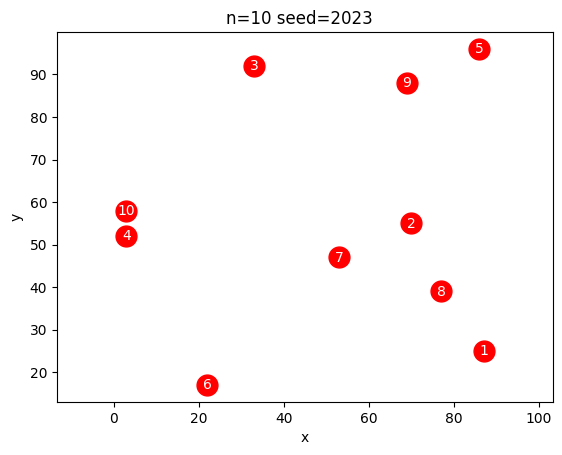

In [ ]:
instance = GenerateTSP(10)
ShowTSP(instance, node_labels=True)

Just to show that the node labels may be very generic, we replace the numerical (1-based) indices by letters. 

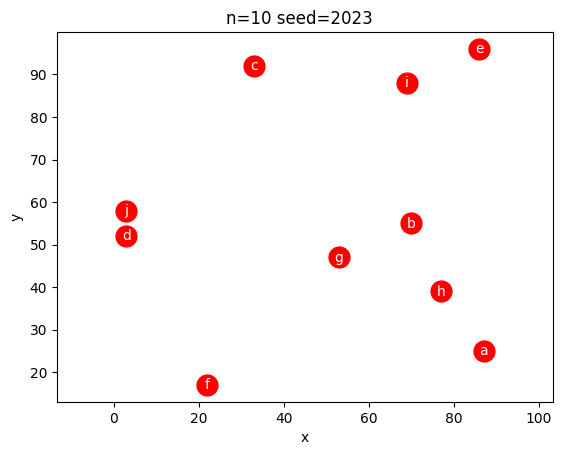

In [ ]:
abc = list(string.ascii_lowercase)
instance["NODE_COORD_SECTION"] = [
    (i, x, y) for (i, (_, x, y)) in zip(abc, instance["NODE_COORD_SECTION"])
]
ShowTSP(instance, node_labels=True)

# The models

Most of the models consider the decision variables: 
$$
   x_{ij} = \left\{
     \begin{array}{lr}
       1 & \text{if node } j \text{ follows node } i \\
       0 & \text{otherwise}                          \\
     \end{array}
   \right.
$$
Later we will see how to reduce these number of variables to (less than) half in case of symmetric distances. 

All models aim at minimizing the total distance traveled: $\sum_{i,j \in N} c_{ij}x_{ij}$.

The models share a core: they model the degree of the nodes and the number of node pairs chosen in the solution.
In the sequel, we refer to a chosen pair $(i,j)$ of nodes as an _arc_, which we may also call an _edge_ in case the distances are symmetric. 
Pair (or arc) $(i,j)$ being chosen means that node $j$ follows node $i$ in the solutions, i.e. $x_{ij} = 1$.

Models based on arcs (i.e. listing all pairs $(i,j)$ of potential choices) share a **bipartite matching** or **linear assignment** core:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}              & =    & 1     & \forall j \in N                       \\
        & \sum_{j \in N} x_{ij}              & =    & 1     & \forall i \in N                       \\
        & x_{ij} \in \{0,1\}                 &      &       & \forall i, j \in N                    
\end{array}
$$
As we learnt from Chapter 4, imposing the integrality (binary nature in this case) of the decision variables on the core model above is redundant, as it is natural integral by nature of its constraint matrix being [TUM](https://en.wikipedia.org/wiki/Unimodular_matrix#Total_unimodularity).

Since this property vanishes as soon as we complement the model in any known way (albeit some [published work](https://arxiv.org/pdf/cs/0609005) erroneously saying otherwise, see also entry 17 of this wonderful [legacy page](https://www.win.tue.nl/~wscor/woeginger/P-versus-NP.htm)) to reach a valid TSP model, we state the variables $x_{ij}$ variables as binary.  

The core model forces the degree of each node to be 2 (one arc entering the node and one leaving it) and also force $n$ arcs to be used (that this is implied by the model above can be easily seen by adding any of the two groups of constraints).

Models vary in the way the way the enforce connectivity, as the core part fails in doing that. In fact, $x_{ii} = 1$ for all $i$ is feasible, but the TSP clearly leaves all vertices. 

An immediate improvement to the core model is just to fix the `self-loops` to 0, i.e. $x_{ii} = 0$, but that is not enough as pairwise loops $x_{ij} = x_{ji} = 1$ become the next culprit.

An inductive reasoning on how to forbid all this _sub-tours_ leads to the well-known [**Dantzig, Fulkerson and Johnson**](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Dantzig%E2%80%93Fulkerson%E2%80%93Johnson_formulation) model 
and formulates the TSP as:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}   & =    & 1     & \forall j \in N                       \\
        & \sum_{j \in N} x_{ij}   & =    & 1     & \forall i \in N                       \\
        & \sum_{i,j \in S} x_{ij} & \leq & |S|-1 & \forall \emptyset \subset S \subset N \\
        & x_{ij} \in \{0,1\}      &      &       & \forall i, j \in N                    \\
\end{array}
$$
The model above prohibits the choice of enough arcs on each subset of nodes to sub-tour on those nodes. 

An equivalent version of the same seems to be more popular, enforcing each subset of nodes to be connected to its complement. 
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}              & =    & 1     & \forall j \in N                       \\
        & \sum_{j \in N} x_{ij}              & =    & 1     & \forall i \in N                       \\
        & \sum_{i \in S, j \not\in S} x_{ij} & \geq & 1     & \forall \emptyset \subset S \subset N \\
        & x_{ij} \in \{0,1\}                 &      &       & \forall i, j \in N                    \\
\end{array}
$$

Since this model requires an exponential number of (so-called sub-tour elimination) constraints we may prefer to start with a more compact model. 

Fortunately, a [compact](https://en.wikipedia.org/wiki/Travelling_salesman_problem#Miller-Tucker-Zemlin_formulation) model exists. 
This ingenious model, devised by C. E. Miller, Alfred E. Tucker and R. A. Zemlin in 1960 adds _sequence_ variables $u_i$ and replace the connectivity (also known as subtour elimination) constraints which are in a exponential number by circa $n^2$ sequence constraints. 

$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij} & =    & 1    & \forall j \in N                              \\
        & \sum_{j \in N} x_{ij} & =    & 1    & \forall i \in N                              \\
        & x_{ij} \in \{0,1\}    &      &      & \forall i, j \in N                           \\
        & u_i - u_j + nx_{ij}   & \leq & n-1  & \forall i,j \in N : 2 \leq i \not = j \leq n \\
        & u_i \in [0,n-2]       &      &      & \forall i \in N                              \\
\end{array}
$$

In fact, this model has been strengthened by several authors, see [this paper](https://www.sciencedirect.com/science/article/pii/S0166218X00003139).

The first improvement is as below:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}   & =    & 1    & \forall j \in N                              \\
        & \sum_{j \in N} x_{ij}   & =    & 1    & \forall i \in N                              \\
        & x_{ij} \in \{0,1\}      &      &      & \forall i, j \in N                           \\
        & u_i - u_j + (n-1)x_{ij} & \leq & n-2  & \forall i,j \in N : 2 \leq i \not = j \leq n \\
        & u_i \in [0,n-2]         &      &      & \forall i \in N                              \\
\end{array}
$$

The best known as below:
$$
\begin{array}{rrcll}
\min    & \sum_{i,j \in N} c_{ij}x_{ij} \\
s.t.    & \sum_{i \in N} x_{ij}                 & =    & 1    & \forall j \in N                              \\
        & \sum_{j \in N} x_{ij}                 & =    & 1    & \forall i \in N                              \\
        & x_{ij} \in \{0,1\}                    &      &      & \forall i, j \in N                           \\
        & u_i - u_j + (n-1)x_{ij} + (n-3)x_{ji} & \leq & n-2  & \forall i,j \in N : 2 \leq i \not = j \leq n \\
        & u_i \in [0,n-2]                       &      &      & \forall i \in N                              \\
\end{array}
$$
These versions of the MTZ model are equivalent in how they model connectivity, but have increasingly tighter linear relaxations.

Below we will consider three MTZ models: the basic one, the one improved by [Desrochers and Laporte](https://www.sciencedirect.com/science/article/pii/0167637791900832) and the best one so far by [Gouveia and Pires](https://www.sciencedirect.com/science/article/pii/S0166218X00003139).

## Building blocks for TSP models 

As the good programmers that we all are, we will strive for modularity and reuse.
We will not regret!

In [ ]:
def LAP(instance):
    I, R = GetIndicesAndReverseLookup(instance)
    C = GetCostMatrix(instance)

    m = pyo.ConcreteModel("LAP")

    m.n = pyo.Param(initialize=len(C), mutable=False)

    m.I = pyo.Set(initialize=I)
    m.IJ = m.I * m.I
    m.c = pyo.Param(m.IJ, initialize=lambda m, i, j: C[R[i], R[j]], mutable=False)
    m.x = pyo.Var(m.IJ, domain=pyo.Binary)

    @m.Objective(sense=pyo.minimize)
    def Cost(m):
        return pyo.quicksum(m.c[i, j] * m.x[i, j] for i, j in m.IJ)

    @m.Constraint(m.I)
    def DepartFromEach(m, i):
        return pyo.quicksum(m.x[i, j] for j in m.I) == 1

    @m.Constraint(m.I)
    def ArriveAtEach(m, i):
        return pyo.quicksum(m.x[j, i] for j in m.I) == 1

    return m

Note that the code below is a bit tricky: the functions **do** modify the model that they take as argument. 
The fact that they return the model could lead into believing that not to be the case, but it is. 
This construction has the convenience of allowing cascading (composing) function calls.

In [ ]:
def ForbidDiagonal(m):
    @m.Constraint(m.I)
    def ForbidStaying(m, i):
        return m.x[i, i] == 0

    return m

In [ ]:
def PrepareMTZ(m):
    skip_first = list(m.I)[1:]
    m.I1 = pyo.Set(initialize=skip_first)
    m.IJ1 = pyo.Set(dimen=2, initialize=it.permutations(skip_first, 2))

    m.u = pyo.Var(m.I1, bounds=(0, m.n - 2))

    return m

In [ ]:
def OriginalMTZ(m):
    @m.Constraint(m.IJ1)
    def MTZ(m, i, j):
        return m.u[i] - m.u[j] + m.n * m.x[i, j] <= m.n - 1

    return m

In [ ]:
def ImprovedMTZ(m):
    @m.Constraint(m.IJ1)
    def MTZ(m, i, j):
        return m.u[i] - m.u[j] + (m.n - 1) * m.x[i, j] <= m.n - 2

    return m

In [ ]:
def BestMTZ(m):
    @m.Constraint(m.IJ1)
    def MTZ(m, i, j):
        return (
            m.u[i] - m.u[j] + (m.n - 1) * m.x[i, j] + (m.n - 3) * m.x[j, i] <= m.n - 2
        )

    return m

## Examining solutions

In [ ]:
def GetNodeSuccessorFromArcVariables(m):
    return {i: j for i, j in m.IJ if m.x[i, j]() > 0.5}


def PartitionSuccessorIntoCycles(successor):
    result = []
    unvisited = set(successor.keys())
    for i in successor.keys():
        if i in unvisited:
            current = i
            cycle = []
            while current in unvisited:
                unvisited.remove(current)
                cycle.append((current, successor[current]))
                current = successor[current]
            result.append(cycle)
    return result


def GetArcsInSolutionPartitionedInCycles(m):
    return PartitionSuccessorIntoCycles(GetNodeSuccessorFromArcVariables(m))

In [ ]:
def ListNodesInSolution(m):
    succ = GetNodeSuccessorFromArcVariables(m)
    sol = [next(iter(succ.keys()))]
    while not succ[sol[-1]] in sol:
        sol.append(succ[sol[-1]])
    sol.append(sol[0])
    return sol

In [ ]:
def GetSolutionFromMTZFollowingU(m):
    sequence = [""] * (m.n() - 1)
    for k, v in m.u.items():
        sequence[int(round(v()))] = k
    return sequence

## Experiments

In [ ]:
mtz_models = [OriginalMTZ, ImprovedMTZ, BestMTZ]

In [ ]:
results = dict()
for f in mtz_models:
    m = f(PrepareMTZ(ForbidDiagonal(LAP(instance))))
    t = pc()
    r = SOLVER.solve(m, tee=False)
    t = pc() - t
    assert GetSolutionFromMTZFollowingU(m) == ListNodesInSolution(m)[1:-1]
    results[f.__name__] = (
        pyo.check_optimal_termination(r),
        round(m.Cost(), 1),
        display_seconds(t),
        "".join(GetSolutionFromMTZFollowingU(m)),
    )
results

{'OriginalMTZ': (True, 307.0, '0:00:00.379', 'gfdjciebh'),
 'ImprovedMTZ': (True, 307.0, '0:00:00.223', 'gfdjciebh'),
 'BestMTZ': (True, 307.0, '0:00:00.203', 'hbeicjdfg')}

We can see that the solution found may differ due to the symmetry of the costs, when drawn they are all the same as the one below (the last one found above). 
Note the special role played by the first node: the tour starts and ends there, therefore the `u` variables list the order of the intermediate nodes. 

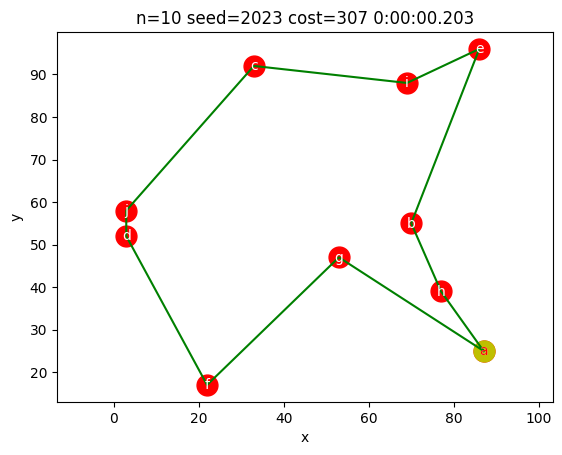

In [ ]:
ShowTSP(instance, ListNodesInSolution(m), True, display_seconds(t))

## How does the strength of the MTZ models differ?

In [ ]:
tsp_dimensions = list(range(5, 101, 5))

In [ ]:
MTZ_bounds = pd.DataFrame(
    index=tsp_dimensions, columns=[f.__name__ for f in mtz_models]
)
for n in tqdm(MTZ_bounds.index):
    instance = GenerateTSP(n)
    for f in mtz_models:
        m = f(PrepareMTZ(ForbidDiagonal(LAP(instance))))
        linear_relaxation.apply_to(m)
        r = SOLVER.solve(m, tee=False)
        assert pyo.check_optimal_termination(r)
        MTZ_bounds.at[n, f.__name__] = m.Cost()
MTZ_bounds.style.format(precision=3)

  0%|          | 0/20 [00:00<?, ?it/s]

,OriginalMTZ,ImprovedMTZ,BestMTZ
5,255.400,257.000,265.000
10,271.300,271.333,286.000
15,232.267,233.143,314.000
20,291.300,291.579,349.000
25,311.080,311.167,347.000
30,312.867,313.034,388.000
35,380.314,380.471,468.000
40,406.125,406.231,487.000
45,453.022,453.091,526.000
50,473.340,473.388,545.500


We can see above the optimal values of the linear relaxations of the three different MTZ models for (on each line) the same instance. 

Note that the instance of 10 nodes that we solved before is the same as in the table above (due to seeding the generator). 

The increase of the third version is quite impressive! 
How is that affecting the times required to solve the integer versions? 

Small spoiler about the remainder of this notebook: it is not wise to try to solve instances of more than 15 nodes with these models! 

In [ ]:
MTZ_times = pd.DataFrame(
    index=tsp_dimensions[:3], columns=[f.__name__ for f in mtz_models] + ["cost"]
)
for n in tqdm(MTZ_times.index):
    cost = []
    instance = GenerateTSP(n)
    for f in mtz_models:
        m = f(PrepareMTZ(ForbidDiagonal(LAP(instance))))
        t = pc()
        r = SOLVER.solve(m, tee=False)
        MTZ_times.at[n, f.__name__] = display_seconds(pc() - t)
        cost.append(np.round(m.Cost()))
    assert len(set(cost)) == 1
    MTZ_times.at[n, "cost"] = int(round(min(cost)))
MTZ_times

  0%|          | 0/3 [00:00<?, ?it/s]

,OriginalMTZ,ImprovedMTZ,BestMTZ,cost
5,0:00:00.020,0:00:00.006,0:00:00.004,269
10,0:00:00.145,0:00:00.153,0:00:00.137,307
15,0:00:00.807,0:00:00.791,0:00:01.108,335


Note that the times above are likely to be very different if you run this notebook on your own machine, even if using the same solver and version. 
In particular, if your machine has more than two (virtual) processors the differences between the models will be much smaller. 
In fact, it may happen that the times taken to optimize do not directly reflect the strength of the model. 

In [ ]:
pd.concat([MTZ_times, MTZ_bounds], axis=1).dropna().style.format(precision=3)

,OriginalMTZ,ImprovedMTZ,BestMTZ,cost,OriginalMTZ,ImprovedMTZ,BestMTZ
5,0:00:00.020,0:00:00.006,0:00:00.004,269,255.400,257.000,265.000
10,0:00:00.145,0:00:00.153,0:00:00.137,307,271.300,271.333,286.000
15,0:00:00.807,0:00:00.791,0:00:01.108,335,232.267,233.143,314.000


# A tale of two models

The DFJ model is hard to use directly, since we would need to explicitly declare $2^n-2$ constraints, and that soon becomes impractical and soon after that, even impossible. 

Our first attempt to grasp its use follows the idea in [this educational paper](https://epubs.siam.org/doi/pdf/10.1137/S00361445023685) in combining DFJ and MTZ. 

The main idea is as follows: 
 * Start by solving the linear assignment model.
 * For each sub-tour in the solution identify the set $S$ and add the corresponding DFJ sub-tour elimination constraint.
 * Solve again and repeat a pre-specified number of (`nof`) times.

At the end of the procedure above we end up with the DFJ model confined to some sub-tour elimination constraints. 
These are redundant for the (mixed integer) MTZ model, but not for its linear relaxation. 
We add the MTZ variables and constraints and solve the resulting mixed model. 

In [ ]:
def AddSomeDFJConstraints(instance, nof, solver):
    optimal_at = None
    m = ForbidDiagonal(LAP(instance))
    m.cuts = pyo.ConstraintList()
    for i in range(nof):
        solver.solve(m)
        cycles = GetArcsInSolutionPartitionedInCycles(m)
        if len(cycles) == 1:
            optimal_at = i
            break
        for cycle in cycles:
            m.cuts.add(pyo.quicksum(m.x[i, j] for (i, j) in cycle) <= len(cycle) - 1)
    return m, optimal_at

In [ ]:
nof = list(range(1, 6))
combined_results = pd.DataFrame(
    index=tsp_dimensions[:5],
    columns=list(it.chain(*[(f"tDFJ.{k}", f"tMTZ.{k}", f"LR.{k}") for k in nof]))
    + ["cost"],
)
for n in tqdm(combined_results.index):
    cost = []
    instance = GenerateTSP(n)
    for k in nof:
        t = pc()
        m, optimal_at = AddSomeDFJConstraints(instance, k, SOLVER)
        combined_results.at[n, f"tDFJ.{k}"] = round(pc() - t, 2)
        if optimal_at is None:
            t = pc()
            m = BestMTZ(PrepareMTZ(m))
            r = SOLVER.solve(m, tee=False)
            combined_results.at[n, f"tMTZ.{k}"] = round(pc() - t, 2)
        cost.append(int(round(m.Cost())))
        linear_relaxation.apply_to(m)
        r = SOLVER.solve(m, tee=False)
        combined_results.at[n, f"LR.{k}"] = m.Cost()
    if not SOLVER == "cbc":
        assert len(set(cost)) == 1, cost
    combined_results.at[n, "cost"] = int(round(min(cost)))
combined_results.style.format(precision=3)

  0%|          | 0/5 [00:00<?, ?it/s]

,tDFJ.1,tMTZ.1,LR.1,tDFJ.2,tMTZ.2,LR.2,tDFJ.3,tMTZ.3,LR.3,tDFJ.4,tMTZ.4,LR.4,tDFJ.5,tMTZ.5,LR.5,cost
5,0.020,0.010,265.000,0.010,0.010,269.000,0.010,nan,269.000,0.010,nan,269.000,0.010,nan,269.000,269
10,0.010,0.020,292.000,0.020,0.020,292.000,0.020,0.030,292.000,0.030,nan,292.000,0.030,nan,292.000,307
15,0.020,0.030,335.000,0.020,0.030,335.000,0.030,nan,335.000,0.030,nan,335.000,0.030,nan,335.000,335
20,0.040,2.320,357.000,0.040,1.650,357.000,0.070,1.340,357.000,0.100,2.420,357.000,0.300,2.190,357.000,380
25,0.050,1.680,355.000,0.070,1.830,355.000,0.140,1.760,355.000,0.250,1.110,355.000,0.480,1.040,355.000,395


In [ ]:
pd.concat([combined_results, MTZ_times, MTZ_bounds], axis=1).dropna(
    subset=["cost"]
).style.format(precision=3)

,tDFJ.1,tMTZ.1,LR.1,tDFJ.2,tMTZ.2,LR.2,tDFJ.3,tMTZ.3,LR.3,tDFJ.4,tMTZ.4,LR.4,tDFJ.5,tMTZ.5,LR.5,cost,OriginalMTZ,ImprovedMTZ,BestMTZ,cost,OriginalMTZ,ImprovedMTZ,BestMTZ
5,0.020,0.010,265.000,0.010,0.010,269.000,0.010,nan,269.000,0.010,nan,269.000,0.010,nan,269.000,269,0:00:00.020,0:00:00.006,0:00:00.004,269,255.400,257.000,265.000
10,0.010,0.020,292.000,0.020,0.020,292.000,0.020,0.030,292.000,0.030,nan,292.000,0.030,nan,292.000,307,0:00:00.145,0:00:00.153,0:00:00.137,307,271.300,271.333,286.000
15,0.020,0.030,335.000,0.020,0.030,335.000,0.030,nan,335.000,0.030,nan,335.000,0.030,nan,335.000,335,0:00:00.807,0:00:00.791,0:00:01.108,335,232.267,233.143,314.000


Note that we have seen `cbc` give _some times_ a wrong answer! Maybe some ill-condition?

# Symmetry

So far, our models include variables $x_{ij}$ for all $i,j \in N$. 
However, if the cost matrix happens to be symmetric (and that is the case is symmetric of all instances studied in this notebook) we may ignore the direction, i.e. consider only one of the two arcs $(i,j)$ or $(j,i)$. 

The number of edges $(i,j)$ for $i < j$ is less than half of the number of arcs. 

The symmetric model can be easily derived from the DFJ model: the linear assignment structure is replaced by constraining each node to have degree 2.

Note that no variant of MTZ is known for the symmetric case! 

In [ ]:
instance = GenerateTSP(50)

552.0 [28, 7, 3, 3, 3, 3, 3]
571.0 [4, 15, 6, 3, 19, 3]
577.0 [36, 4, 4, 6]
581.0 [3, 16, 11, 20]
583.0 [33, 17]
583.0 [50]


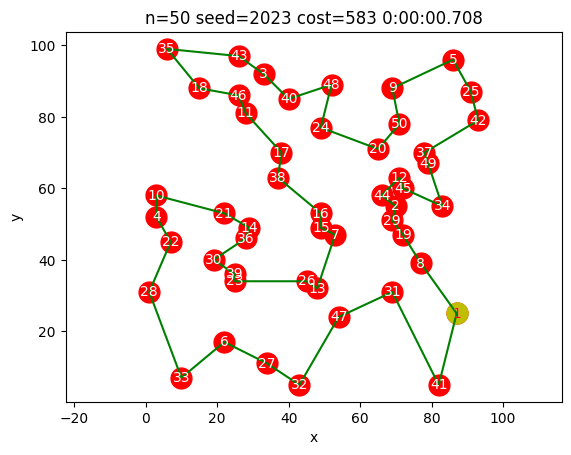

In [ ]:
def SymmetricBasicModel(instance):
    I, R = GetIndicesAndReverseLookup(instance)
    C = GetCostMatrix(instance)
    m = pyo.ConcreteModel("STSP")
    m.n = pyo.Param(initialize=len(I))
    m.I = pyo.Set(initialize=I)
    m.E = pyo.Set(initialize=it.combinations(I, 2))
    m.x = pyo.Var(m.E, domain=pyo.Binary)
    m.C = pyo.Param(m.E, initialize=lambda m, i, j: C[R[i], R[j]])

    @m.Objective(sense=pyo.minimize)
    def Cost(m):
        return pyo.quicksum(m.C[e] * m.x[e] for e in m.E)

    @m.Constraint(m.I)
    def enter_and_leave(m, i):
        return pyo.quicksum(m.x[e] for e in m.E if i in set(e)) == 2

    return m


def GetSelected(m):
    return [e for e in m.E if m.x[e]() > 0.5]


def GetAdjacent(selected, I):
    adjacent = {i: [] for i in I}
    for i, j in selected:
        adjacent[i].append(j)
        adjacent[j].append(i)
    return adjacent


def GetSubTours(adjacent):
    all_nodes = set(list(adjacent.keys()))
    sub_tours = []
    while len(all_nodes) > 0:
        node = next(iter(all_nodes))
        tour = [node]
        all_nodes.remove(node)
        while not all(j in tour for j in adjacent[tour[-1]]):
            for j in adjacent[tour[-1]]:
                if j not in tour:
                    tour.append(j)
                    all_nodes.remove(j)
                    break
        sub_tours.append(tour)
    return sub_tours


t = pc()

m = SymmetricBasicModel(instance)
m.ellim = pyo.ConstraintList()

while True:
    SOLVER.solve(m)
    sub_tours = GetSubTours(GetAdjacent(GetSelected(m), m.I))
    print(round(m.Cost(), 1), [len(S) for S in sub_tours])
    if len(sub_tours[0]) == m.n:
        break
    for S in sub_tours:
        m.ellim.add(
            pyo.quicksum(m.x[e] for e in m.E if all(i in S for i in e)) <= len(S) - 1
        )

ShowTSP(instance, sol=sub_tours[0], node_labels=True, how=display_seconds(pc() - t))

## Callbacks

So far, we extended our model by adding the needed constraints and the solved again. 

Some solvers support a more sophisticated way to add constraints while solving. 
The mechanism to do so is called a _callback_: a function that we define and offer to the solver to call while solving the problem. 

The solver can do this at different moments. 
For us, the moment of interest is when the solver finds a feasible solution: we can check if it satisfies all the not yet defined constraints, and if needed add some new constraints.

`Pyomo` supports callbacks for using with `gurobi`, `cplex` and `express`.
These are all commercial solvers, of which the free (community edition) of gurobi is the most generous, allowing for up to 2000 variables and/or constraints. 


In [ ]:
import gurobipy as gp
from gurobipy import GRB

In [ ]:
def my_callback(cb_m, cb_opt, cb_where):
    if cb_where == GRB.Callback.MIPSOL:
        cb_opt.cbGetSolution(vars=[cb_m.x[e] for e in cb_m.E])
        sub_tours = GetSubTours(GetAdjacent(GetSelected(cb_m), cb_m.I))
        if len(sub_tours) > 1:
            for S in sub_tours:
                cb_opt.cbLazy(
                    cb_m.ellim.add(
                        pyo.quicksum(
                            cb_m.x[e] for e in cb_m.E if all(i in S for i in e)
                        )
                        <= len(S) - 1
                    )
                )

In [ ]:
t = pc()

m = SymmetricBasicModel(instance)
m.ellim = pyo.ConstraintList()
COMMERCIAL_SOLVER.set_instance(m)
COMMERCIAL_SOLVER.set_gurobi_param("OutputFlag", 0)
COMMERCIAL_SOLVER.set_gurobi_param("PreCrush", 1)
COMMERCIAL_SOLVER.set_gurobi_param("LazyConstraints", 1)
COMMERCIAL_SOLVER.set_callback(my_callback)
r = COMMERCIAL_SOLVER.solve()

t = pc() - t

Restricted license - for non-production use only - expires 2024-10-28


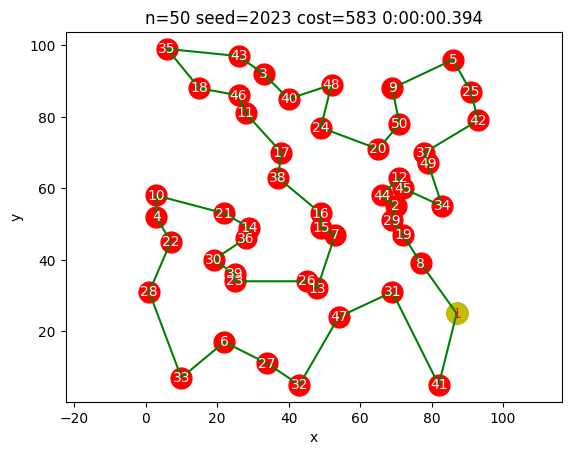

In [ ]:
ShowTSP(
    instance,
    sol=GetSubTours(GetAdjacent(GetSelected(m), m.I))[0],
    node_labels=True,
    how=display_seconds(t),
)

## Gray area

Defining a callback forces us to adhere to solver specific knowledge. 

One may argue that the flexibility offered by `pyomo` is now somewhat lost. 

Maybe this is the moment to consider modeling the whole model in the solver's dialect (`gurobipy` in this case) and bypass the overhead of `pyomo` all together. 

In [ ]:
def SymmetricTSPViaGurobi(C, trace):
    assert np.allclose(C, C.T, rtol=1e-05, atol=1e-08), "cost should be symmetric"

    m = gp.Model()

    m._n = len(C)
    m._I = range(m._n)
    m._E = list(it.combinations(m._I, 2))

    m._x = m.addVars(
        m._E, obj={(i, j): C[i, j] for (i, j) in m._E}, vtype=GRB.BINARY, name="x"
    )
    m.addConstrs(m._x.sum(i, "*") + m._x.sum("*", i) == 2 for i in m._I)

    def GetSelected(x):
        return [e for e, v in x.items() if v > 0.5]

    def subtourelim(model, where):
        if where == GRB.Callback.MIPSOL:
            sub_tours = GetSubTours(
                GetAdjacent(GetSelected(model.cbGetSolution(model._x)), model._I)
            )
            for tour in sub_tours:
                if len(tour) < model._n:
                    model.cbLazy(
                        gp.quicksum(
                            model._x[i, j] for i, j in it.combinations(sorted(tour), 2)
                        )
                        <= len(tour) - 1
                    )

    m.Params.OutputFlag = trace
    m.Params.LazyConstraints = 1
    m.optimize(subtourelim)

    sub_tours = GetSubTours(GetAdjacent(GetSelected(m.getAttr("X", m._x)), m._I))
    assert len(sub_tours) == 1, sub_tours
    tour = sub_tours[0]
    assert len(tour) == m._n, tour

    m.printStats()

    return tour

In [ ]:
def GurobiSymmetric(instance, trace):
    C = GetCostMatrix(instance)

    tour = SymmetricTSPViaGurobi(C, trace)

    I, _ = GetIndicesAndReverseLookup(instance)

    return [I[i] for i in tour]

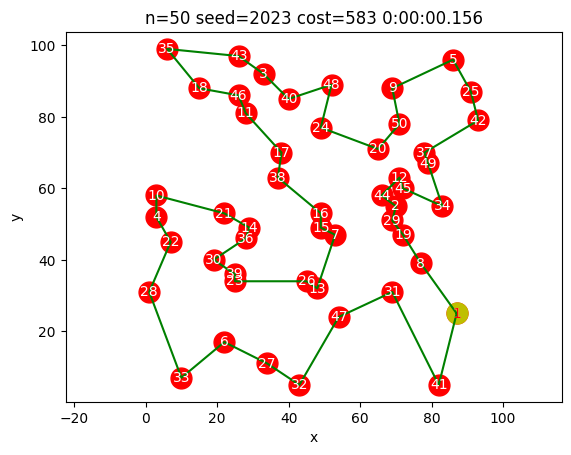

In [ ]:
t = pc()
sol = GurobiSymmetric(instance, False)
t = pc() - t
ShowTSP(instance, sol=sol, node_labels=True, how=display_seconds(t))

Since the number of variables is $n(n-1)/2$ dominates the number of explicit constraints $n$, the highest $n$ that fits the community edition is $n=63$ yielding $1953$ variables and $63$ constraints. 

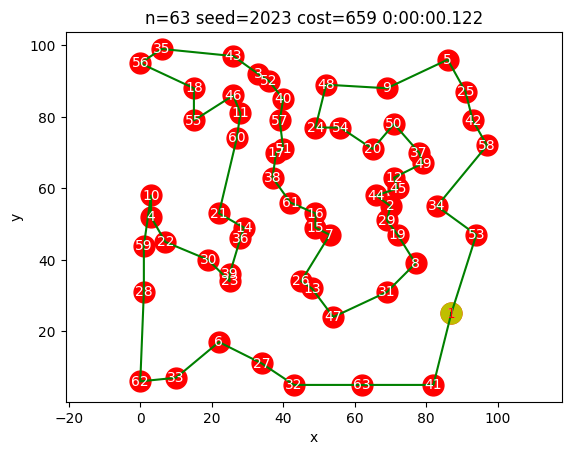

In [ ]:
instance = GenerateTSP(63)
t = pc()
sol = GurobiSymmetric(instance, False)
t = pc() - t
ShowTSP(instance, sol=sol, node_labels=True, how=display_seconds(t))

Very fast, right? Maybe we can try some of the benchmarks now!

## Famous benchmark instances from the Internet

In [ ]:
def ReadTextFromURL(url):
    return requests.get(url).text


def NumberOrString(text):
    if text.isdigit():
        return int(text)
    elif text.replace(".", "", 1).isdigit():
        return float(text)
    else:
        return text


def LeftPart(lineWithColon):
    return lineWithColon.split(":")[0].strip()


def RightPart(lineWithColon):
    return NumberOrString(lineWithColon.split(":", 1)[1].strip())


def ParseComment(comment):
    asList = comment.replace("(", "").replace(")", "").split(",")
    result = {LeftPart(line): RightPart(line) for line in asList if ":" in line}
    result["COMMENT"] = ",".join([line for line in asList if not ":" in line])
    return result


def Dispatch(name, *args, **kwargs):
    dispatcher = {"DIMENSION": int, "CAPACITY": int, "COMMENT": ParseComment}
    if name in dispatcher.keys():
        return dispatcher[name](*args, **kwargs)
    else:
        return NumberOrString(*args, **kwargs)


def ReadCVRP(text):
    lines = [line for line in text.split("\n") if len(line) > 0]
    if not "EOF" in lines[-1]:
        lines.append("EOF")
    instance = {
        LeftPart(line): Dispatch(LeftPart(line), RightPart(line))
        for line in lines
        if ":" in line
    }
    idxSections = [
        i for i, line in enumerate(lines) if "SECTION" in line or "EOF" in line
    ]
    for i, idx in enumerate(idxSections[:-1]):
        key = lines[idx].strip()
        instance[key] = [
            [NumberOrString(x) for x in line.split()]
            for line in lines[idx + 1 : idxSections[i + 1]]
        ]
    return instance


def GetNationalTSP(filename):
    return ReadCVRP(
        ReadTextFromURL("http://www.math.uwaterloo.ca/tsp/world/" + filename)
    )

In [ ]:
world = "https://www.math.uwaterloo.ca/tsp/world/"

In [ ]:
tt = pd.read_html(f"{world}summary.html")[-1]
tt.rename(columns=tt.iloc[0], inplace=True)
tt.drop(tt.index[0], inplace=True)
tt["size"] = tt["Name"].str.extract("(\d+)").astype(int)
tt.sort_values("size", inplace=True, ignore_index=True)
tt

,Name,Gap,Bound,Tour,Source of Tour,size
0,wi29,Optimal,27603,27603,Concorde,29
1,dj38,Optimal,6656,6656,Concorde,38
2,qa194,Optimal,9352,9.352,Concorde,194
3,uy734,Optimal,79114,79114,Concorde,734
4,zi929,Optimal,95345,95345,Concorde,929
5,lu980,Optimal,11340,11340,Concorde,980
6,rw1621,Optimal,26051,26051,Concorde,1621
7,mu1979,Optimal,86891,86891,Concorde,1979
8,nu3496,Optimal,96132,96132,Concorde,3496
9,ca4663,Optimal,1290319,1290319,Concorde,4663


Well, these sizes soon become too large for us! 
Definitely for the community edition of `gurobi` (we can go up to the first two).
Actually, this technique becomes impractical soon after that, even when having a `gurobi` license in place. 
No mather how good the model is, the problem is still very hard! 
The solutions listed above where found by highly researched solvers, specific for the TSP. 

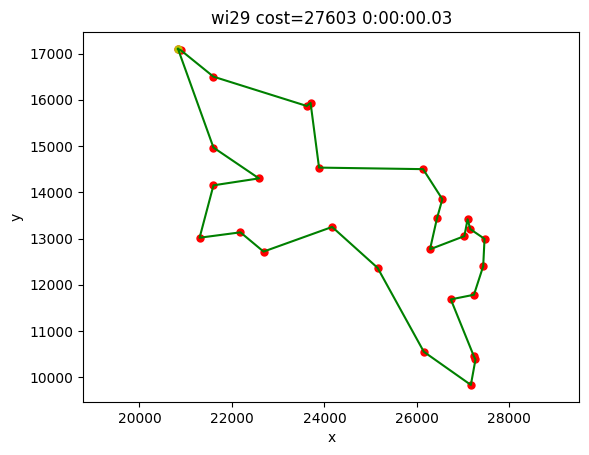

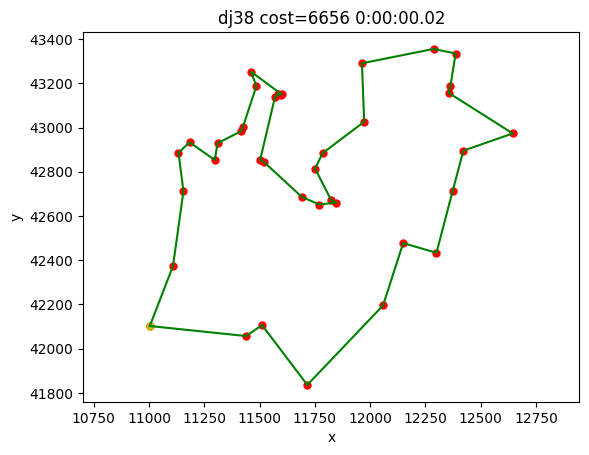

In [ ]:
for name in tt.Name[:2]:
    instance = GetNationalTSP(f"{name}.tsp")
    t = pc()
    sol = GurobiSymmetric(instance, False)
    ShowTSP(
        instance, sol=sol, node_labels=False, how=str(timedelta(seconds=pc() - t))[:-4]
    )

# Beyond this?

Maybe read [the book](https://www.math.uwaterloo.ca/tsp/book/index.html) and write your own TSP solver or just run [concorde](https://github.com/jvkersch/pyconcorde).